In [760]:
import yfinance as yf
import pandas as pd

def create_df_for_multi_companies(
        raw_data_multiindex:pd.MultiIndex, 
        stock_var:str, 
        companies:list[str]):
    
    raw_values = {}
    for company in companies:
        # Transform MultiIndex DF into SingleIndex DF for each company with all prices (Open, Close... Adj. Close)
        raw_data_by_company = raw_data_multiindex.xs(key=company, level='Ticker', axis=1, drop_level=False)
        # Grab only the Datetime and the desired price (e.g., colums -> [Datetime | Open])
        raw_data_series = raw_data_by_company[(stock_var,company)]
        # Make a dictionary of type {company[x] : [Open Values 0, 1, ... N] ... }
        raw_values[company] = raw_data_series.values
    # Create 'df' Dataframe only with "Datetime" Column
    df = pd.DataFrame({'Datetime':raw_data_series.index})
    # Append all columns with values for each company, resulting in [Datetime | Company_values[x] ...]
    df = df.assign(**raw_values)
    return df

def get_finance_df(
        companies:str|list[str], 
        start_date:str, 
        end_date:str, 
        stock_var:str='Adj Close') -> pd.DataFrame:
    
    try:
        # In case companies is a string, transform into a list of 1 object, like: ['company']
        if not isinstance(companies,list):
            companies:list[str] = [companies]
        
        # Download data using yfinance
        raw_data_multiindex:pd.MultiIndex = yf.download(tickers=companies, start=start_date, end=end_date)

        # Transform the raw data into a suitable DF
        df = create_df_for_multi_companies(raw_data_multiindex, stock_var, companies)

        return df
    
    except:
            Exception("Unexpected error: something wrong occurred while creating the finance DF")


def split_train_test_valid_df(df, horizon_pred=1, seq_length=30, size_train_percent=0.75, size_test_percent=0.2):
    N = len(df)-seq_length-horizon_pred
    Ntrain = int(size_train_percent*N)
    Ntest = int(size_test_percent*N)
    
    df_train = df.loc[0:Ntrain]
    df_test = df.loc[Ntrain+1:Ntrain+Ntest]
    df_valid = df.loc[Ntrain+Ntest+1:]

    Nvalid = len(df_valid)
    if (Nvalid < (seq_length+horizon_pred+1)):
        raise ValueError(f"""At least (seq_length+horizon_pred+1) samples are needed for validation. You have seq_length={seq_length}, horizon_pred={horizon_pred} and Nvalid={Nvalid} samples, with Ntrain={Ntrain}, Ntest={Ntest} and N={N}. Try changing the prediction horizon, the sequence/window length, or increasing the number of samples""")

    return (df_train, df_test, df_valid)

def shift_drop_na_in_xy(df, company_inputs, company_output, horizon_pred):
    new_df = pd.concat([df[company_inputs], df[company_output].rename("target").shift(-horizon_pred)],axis='columns').dropna()
    X = new_df[company_inputs].values
    y = new_df["target"].values
    return X, y

In [761]:
# from feature_engineering import get_finance_df

# Load dataset
company_inputs = ['PETR4.SA', 'BZ=F', '6L=F']
# company_inputs = ['PETR4.SA', 'BZ=F']
# company_inputs = ['PETR4.SA', '6L=F']
# company_inputs = ['PETR4.SA']
company_output = 'PETR4.SA'
end_date = '2024-10-01' 
start_date = '2020-01-01'
stock_var = 'Adj Close'

horizon_pred = 1
seq_length = 30
batch_size = 30
train_ratio = 0.75
test_ratio = 0.2

units_layer1 = 200
activation_layer1 = 'relu'
dropout_layer1 = 0.2
units_layer2 = None
activation_layer2 = None if units_layer2 is None else 'relu'
dropout_layer2 = None if units_layer2 is None else 0.1
activation_output = 'relu'

optim = 'adam'
loss_fn = 'mse'
n_epochs = 150

df = get_finance_df(company_inputs, start_date, end_date, stock_var)
df = df.interpolate(method='linear')
# df = df.fillna(0)
# df.dropna()

n_inputs = len(company_inputs)

print(df)
print(n_inputs)


[*********************100%***********************]  3 of 3 completed


                      Datetime   PETR4.SA       BZ=F     6L=F
0    2020-01-02 00:00:00+00:00  10.621440  66.250000  0.24810
1    2020-01-03 00:00:00+00:00  10.534945  68.599998  0.24655
2    2020-01-06 00:00:00+00:00  10.659495  68.910004  0.24625
3    2020-01-07 00:00:00+00:00  10.617979  68.269997  0.24590
4    2020-01-08 00:00:00+00:00  10.552242  65.440002  0.24695
...                        ...        ...        ...      ...
1220 2024-09-24 00:00:00+00:00  36.779999  75.169998  0.18335
1221 2024-09-25 00:00:00+00:00  37.049999  73.459999  0.18255
1222 2024-09-26 00:00:00+00:00  36.250000  71.599998  0.18380
1223 2024-09-27 00:00:00+00:00  36.110001  71.980003  0.18400
1224 2024-09-30 00:00:00+00:00  36.009998  71.769997  0.18355

[1225 rows x 4 columns]
3


In [762]:
df_train, df_test, df_valid = split_train_test_valid_df(df=df, 
    horizon_pred=horizon_pred, seq_length=seq_length, 
    size_train_percent=train_ratio, size_test_percent=test_ratio
    )

In [763]:
X_train, y_train = shift_drop_na_in_xy(df_train, company_inputs, company_output, horizon_pred=horizon_pred)
X_test, y_test = shift_drop_na_in_xy(df_test, company_inputs, company_output, horizon_pred=horizon_pred)
X_valid, y_valid = shift_drop_na_in_xy(df_valid, company_inputs, company_output, horizon_pred=horizon_pred)

In [764]:
X_train[0:3], y_train[0:3]

(array([[10.62143993, 66.25      ,  0.2481    ],
        [10.53494549, 68.59999847,  0.24654999],
        [10.65949535, 68.91000366,  0.24625   ]]),
 array([10.53494549, 10.65949535, 10.61797905]))

In [765]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler

# Normalize the Price column
scalerX = MinMaxScaler()
scalery = MinMaxScaler()
scaled_X_train = scalerX.fit_transform(X_train)
scaled_y_train = scalery.fit_transform(y_train.reshape(-1, 1))

scaled_X_test = scalerX.transform(X_test)
scaled_y_test = scalery.transform(y_test.reshape(-1, 1))

scaled_X_valid = scalerX.transform(X_valid)
scaled_y_valid = scalery.transform(y_valid.reshape(-1, 1))

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Initialize generator with multivariable input and single target
generator_train = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=seq_length, batch_size=batch_size)
generator_test = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=seq_length, batch_size=batch_size)
generator_valid = TimeseriesGenerator(scaled_X_valid, scaled_y_valid, length=seq_length, batch_size=batch_size)


In [766]:
scaled_X_train, scaled_y_train

(array([[0.30383984, 0.43184536, 1.        ],
        [0.29992637, 0.45347443, 0.98053981],
        [0.30556168, 0.45632768, 0.97677346],
        ...,
        [0.94716717, 0.52393004, 0.49403645],
        [0.95270892, 0.52066268, 0.50156935],
        [1.        , 0.5318914 , 0.51663533]]),
 array([[0.29992637],
        [0.30556168],
        [0.30368325],
        [0.30070897],
        [0.29914364],
        [0.29710868],
        [0.29804791],
        [0.2928822 ],
        [0.28583789],
        [0.2853683 ],
        [0.29053405],
        [0.2928822 ],
        [0.28693372],
        [0.28176801],
        [0.2874034 ],
        [0.28192447],
        [0.26204418],
        [0.27409765],
        [0.27488029],
        [0.27628916],
        [0.26861872],
        [0.26439233],
        [0.2714365 ],
        [0.26767957],
        [0.28004609],
        [0.27613261],
        [0.27926336],
        [0.2847422 ],
        [0.29491699],
        [0.28849909],
        [0.28380297],
        [0.2828637 ],
     

In [767]:
Xgen_train, ygen_train = generator[0]

In [768]:
scalerX.inverse_transform(Xgen_train[0]), scalery.inverse_transform(ygen_train[0].reshape(-1,1)) 

(array([[12.93228479, 75.57365158,  0.2481    ],
        [12.85878079, 77.56870811,  0.24760238],
        [12.96462474, 77.83189036,  0.24750608],
        [12.92934369, 77.2885495 ,  0.24739371],
        [12.87347981, 74.88599542,  0.2477308 ],
        [12.84407934, 74.82656842,  0.2469282 ],
        [12.80585801, 74.49547424,  0.24707267],
        [12.82349893, 73.83327939,  0.24588482],
        [12.72647504, 74.07947879,  0.24601324],
        [12.59416687, 73.66348982,  0.2452909 ],
        [12.58534681, 74.18984784,  0.2448896 ],
        [12.68237151, 74.38510519,  0.24548352],
        [12.72647504, 19.32999992,  0.16845   ],
        [12.61474889, 74.16437357,  0.24490565],
        [12.517725  , 72.99281003,  0.24513038],
        [12.62357057, 71.99952747,  0.24546747],
        [12.52066367, 70.85342848,  0.24509827],
        [12.14726632, 69.69035312,  0.24474513],
        [12.3736581 , 69.8516545 ,  0.2448896 ],
        [12.38835793, 70.10634532,  0.24455251],
        [12.41481972

In [769]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Define the LSTM model

if (units_layer2 is None) or (activation_layer2 is None):
    print("layers = 1")
    model = Sequential([
        LSTM(units=units_layer1, activation=activation_layer1, input_shape=(seq_length, n_inputs)),
        Dropout(rate=dropout_layer1),
        Dense(1, activation=activation_output)
    ])
else:
    print("layers = 2")
    model = Sequential([
        LSTM(units=units_layer1, activation=activation_layer1, input_shape=(seq_length, n_inputs), return_sequences=True),
        Dropout(rate=dropout_layer1),
        LSTM(units=units_layer2, activation=activation_layer2),
        Dropout(rate=dropout_layer2),
        Dense(1, activation=activation_output)
    ])

model.compile(optimizer=optim, loss=loss_fn)

# Train the model
model.fit(generator_train, epochs=n_epochs, validation_data=generator_test)


layers = 1
Epoch 1/150


c:\GitRepos\TC4-Thales\tech_challenge_4\training_model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\GitRepos\TC4-Thales\tech_challenge_4\training_model\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1877 - val_loss: 1.6698
Epoch 2/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2288 - val_loss: 1.6698
Epoch 3/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1450 - val_loss: 1.6698
Epoch 4/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.2234 - val_loss: 1.6698
Epoch 5/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.2024 - val_loss: 1.6698
Epoch 6/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1763 - val_loss: 1.6698
Epoch 7/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1868 - val_loss: 1.6698
Epoch 8/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1832 - val_loss: 1.6698
Epoch 9/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.2012 - val_loss: 1.6698
Epoch 10/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1931 - val_loss: 1.6698
Epoch 11/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1821 - val_loss: 1.6698
Epoch 12/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.2

In [770]:
X_gen_valid, y_gen_valid = generator_valid[0]
y_pred_scaled = model.predict(X_gen_valid).reshape(-1,)
print(y_pred_scaled)
print(y_gen_valid[1:].reshape(-1,))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
[1.387926  1.4046755 1.4220102 1.4236643 1.426499  1.423317  1.4279344
 1.4297603 1.432482  1.4291526 1.4309449 1.4165946 1.39357   1.384622
 1.382936  1.3833556 1.369459  1.3551402 1.3637782 1.3557752 1.3272564
 1.3083515 1.3178706 1.3276145 1.3498383 1.3575125 1.3776163 1.3843158
 1.3990763 1.4198625]
[1.49809496 1.50953333 1.50161457 1.51701215 1.51261282 1.52141149
 1.51833183 1.52537087 1.49149587 1.46993933 1.48313733 1.48093757
 1.47917794 1.44574307 1.43562455 1.46905942 1.44398327 1.39515064
 1.39383079 1.4211067  1.41890711 1.44442305 1.42946541 1.46597994
 1.45586142 1.48445701 1.50997329 1.51701215 1.51437245]


In [771]:
y_pred = scalery.inverse_transform(y_pred_scaled.reshape(-1,1))
y_valid_f = scalery.inverse_transform(y_gen_valid.reshape(-1,1))
print(y_pred.T, y_valid_f.T)

[[34.5816   34.95179  35.33492  35.37148  35.434128 35.3638   35.465855
  35.50621  35.566364 35.49278  35.53239  35.215225 34.70634  34.508575
  34.471313 34.480587 34.173447 33.856976 34.047894 33.871014 33.2407
  32.82287  33.033257 33.24861  33.739796 33.90941  34.353737 34.50181
  34.82804  35.287453]] [[37.36656189 37.01652145 37.26932907 37.09431076 37.43462372 37.3373909
  37.53185654 37.46379089 37.61936569 36.87067032 36.3942337  36.68593216
  36.63731384 36.598423   35.85945511 35.63581848 36.37478638 35.82056046
  34.74127579 34.7121048  35.31494904 35.26633453 35.8302803  35.49969101
  36.30672455 36.08308792 36.71509933 37.27905273 37.43462372 37.37628174]]


In [779]:
from sklearn.metrics import root_mean_squared_error, r2_score

delay = 2
offset = 2

rmse = root_mean_squared_error(y_pred[delay:]+offset, y_valid_f[0:-delay])
r2 = r2_score(y_pred[delay:]+offset, y_valid_f[0:-delay])

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

RMSE: 0.2330
R² Score: 0.9225


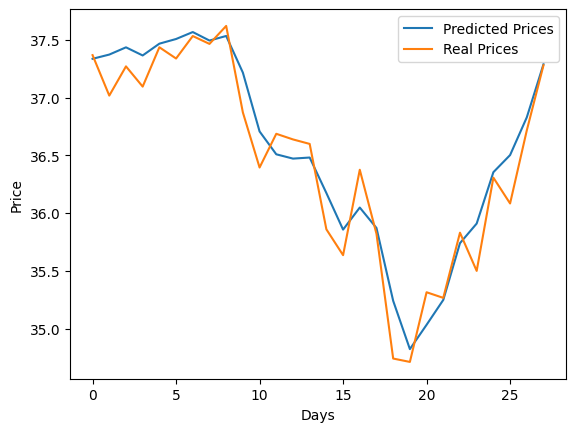

In [780]:
import matplotlib.pyplot as plt

# Plot the predicted prices
plt.plot(y_pred[delay:]+offset, label="Predicted Prices")
plt.plot(y_valid_f[0:-delay], label="Real Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

In [774]:
# import mlflow
# import mlflow.tensorflow

# mlflow.set_tracking_uri(uri="http://127.0.0.1:7777")
# mlflow.set_experiment("LSTM Experiments")

# from sklearn.metrics import root_mean_squared_error, r2_score

# mlflow.tensorflow.autolog()
# with mlflow.start_run():
#     mlflow.tensorflow.log_model(model, "model")

#     # Calculate RMSE and R² score
#     rmse = root_mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     print(f'RMSE: {rmse:.4f}')
#     print(f'R² Score: {r2:.4f}')

#     mlflow.log_metric("RMSE", rmse)
#     mlflow.log_metric("R2-Score", r2)

In [775]:
# # Predict using the trained model
# future_steps = 10  # Number of days to predict
# future_data = data[-n_steps:].reshape(-1, n_steps, 1)
# predicted_prices = []

# for i in range(future_steps):
#     prediction = model.predict(future_data)[0, 0]
#     predicted_prices.append(prediction)
#     future_data = np.roll(future_data, -1, axis=1)
#     future_data[0, -1] = prediction

# # Inverse transform the predicted prices to original scale
# predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()

In [776]:
# import matplotlib.pyplot as plt

# # Plot the predicted prices
# plt.plot(predicted_prices, label="Predicted Prices")
# plt.xlabel("Days")
# plt.ylabel("Price")
# plt.legend()
# plt.show()